In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkish-political-vocabulary/Turkish_Advanced_Political_Vocabulary.csv
/kaggle/input/turkish-political-vocabulary/Turkish_Advanced_Political_Vocabulary_5000.csv
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/config.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/tokenizer.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/metadata.json
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/model.weights.h5
/kaggle/input/gemma2/keras/gemma2_instruct_2b_en/1/assets/tokenizer/vocabulary.spm
/kaggle/input/gemma-language-tuning/submission_instructions.txt


In [2]:
import os
import keras_nlp
import keras
import pandas as pd
import time
from tqdm.notebook import tqdm

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

In [4]:
os.environ["KERAS_BACKEND"]="jax"

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

class Config:
    token_limit=256
    lora_name="Turkish_Lora"
    lora_rank=4
    lr_value=1e-5
    train_epoch=5
    model_id = "gemma2_instruct_2b_en"

In [5]:
df = pd.read_csv('/kaggle/input/turkish-political-vocabulary/Turkish_Advanced_Political_Vocabulary_5000.csv')
df.head(1)

,Word/Phrase,Meaning,Usage in Sentence
0,Egemenlik,Opposition,"Egemenlik, günümüz siyasetinde bir dönüm nokta..."


In [6]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(Config.model_id)
gemma = keras_nlp.models.GemmaCausalLM.from_preset(Config.model_id)
gemma.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [7]:
train = []

for i,x in tqdm(df.iterrows(), desc='tokenize dataset'):
    item = f"<start_of_turn>user\n{x['Word/Phrase']}<end_of_turn>\n<start_of_turn>system\n{x['Usage in Sentence']}<end_of_turn>"
    length = len(tokenizer(item))
    if length < Config.token_limit:
        train.append(item)

print(len(train))
print(train[0])
print(train[1])
print(train[4])

tokenize dataset: 0it [00:00, ?it/s]

9000
<start_of_turn>user
Egemenlik<end_of_turn>
<start_of_turn>system
Egemenlik, günümüz siyasetinde bir dönüm noktasıdır.<end_of_turn>
<start_of_turn>user
Bağımsızlık<end_of_turn>
<start_of_turn>system
Bağımsızlık, demokrasinin işleyişinde kritik bir rol oynar.<end_of_turn>
<start_of_turn>user
İnsan hakları<end_of_turn>
<start_of_turn>system
İnsan hakları kavramı modern siyaset biliminin temelini oluşturur.<end_of_turn>


In [8]:
tick_start = 0


def tick():
    global tick_start
    tick_start = time.time()


def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=Config.token_limit)
    print("\nGemma output:")
    print(output)
    tock()

In [9]:
text_gen('Türkiye bir hukuk devleti olarak sayılır ama bunun hakkında bazı potansiyel şüpheler mevcuttur. Sence bu doğru mu?')


Gemma output:
<start_of_turn>user
Türkiye bir hukuk devleti olarak sayılır ama bunun hakkında bazı potansiyel şüpheler mevcuttur. Sence bu doğru mu?<end_of_turn>
<start_of_turn>model
Türkiye'nin hukuk devleti olarak kabul edilmesinin doğru olup olmadığı, tartışmalı bir konudur. 

**Argümanlar:**

**Hukuk Devleti Özellikleri:**

* **Yasal düzenlemeler:** Türkiye, yasal düzenlemeler ve hukuki sistemde belirli bir temel ve kurallar sunar. 
* **Yargı sistemi:** Türkiye'de yargı sistemi mevcuttur ve yasal süreçler ve hukuki kararlar alınır. 
* **Hukuk profesyonelleri:** Türkiye'de hukuk profesyonelleri bulunmaktadır ve hukuki hizmetler sunulmaktadır. 

**Şüpheler:**

* **Yasal uygulama:** Yasal düzenlemelerin uygulanması ve uygulamada adil bir şekilde uygulanması konusunda bazı şüpheler bulunmaktadır. 
* **Yargı bağımsızlığı:** Yargı bağımsızlığı konusunda bazı endişeler bulunmaktadır. 
* **Güvenilirlik:** Türkiye'de hukuk sistem
TOTAL TIME ELAPSED: 36.20s


In [10]:
gemma.backbone.enable_lora(rank=Config.lora_rank)
gemma.summary()


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [11]:
gemma.preprocessor.sequence_length = Config.token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=Config.lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [12]:
df.tail()

,Word/Phrase,Meaning,Usage in Sentence
8995,Devlet politikası,Parliament,Bir toplumun Devlet politikası ilkelerine bağl...
8996,Sivil toplum,State policy,Sivil toplum konusunda yapılan reformlar geniş...
8997,Yolsuzluk,International relations,Yolsuzluk üzerine yoğun tartışmalar yaşanmakta...
8998,Çoğulculuk,Civil society,Çoğulculuk konusunda yapılan reformlar geniş y...
8999,Temsili demokrasi,Public opinion,Temsili demokrasi perspektifinden bakıldığında...


Epoch 1/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.3016 - sparse_categorical_accuracy: 0.7093
Gemma output:
<start_of_turn>user
Which country type is Turkey considered to be?<end_of_turn>
<start_of_turn>model
Bir ülkenin tipi, demokrasinin işleyişinde kritik bir rol oynar.<end_of_turn>
TOTAL TIME ELAPSED: 29.83s

Gemma output:
<start_of_turn>user
the meaning of sovereignty<end_of_turn>
<start_of_turn>model
Sovereignty, bir demokrasinin işleyişinde kritik bir rol oynar.<end_of_turn>
TOTAL TIME ELAPSED: 0.80s
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 3902s 425ms/step - loss: 0.3016 - sparse_categorical_accuracy: 0.7093
Epoch 2/5
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.0515 - sparse_categorical_accuracy: 0.8937
Gemma output:
<start_of_turn>user
Which country type is Turkey considered to be?<end_of_turn>
<start_of_turn>model
Bir toplumun siyasi yapısı farklı görüşlere sahiptir.<end_of_turn>
TOTAL TIME ELAPSED: 0.67s

Gemma output:
<start_of_turn>user
the meaning of sovere

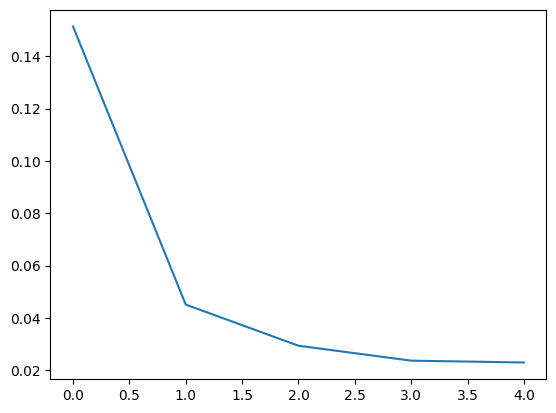

In [13]:
class CustomCallback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        model_name = f"/kaggle/working/{Config.lora_name}_{Config.lora_rank}_last.lora.h5"
        gemma.backbone.save_lora_weights(model_name)

        # Evaluate
        text_gen("Which country type is Turkey considered to be?")
        text_gen(
          "the meaning of sovereignty"
        )
       
history = gemma.fit(train, epochs=Config.train_epoch, batch_size=1, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()